# Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_Learning-USU/blob/main/Lectures%20and%20codes/Module%206-%20Deep%20Sequence%20Modeling/python/Module%206-%20Deep%20sequence%20modeling-RNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 6- Deep Sequence Modeling (Part 1: RNN, LSTM)

This module provides a comprehensive overview of fundamental concepts and techniques related to deep sequence modeling. Part one explores deep learning for timeseries data, highlighting the inadequacy of DNN and CNN architectures for this task and introducing the recurrent neural network (RNN) as a solution. Part two delves into deep learning for natural language processing (NLP), illustrating how neural networks can be employed to process human language. The module concludes with a practical exercise in which students apply the concepts they have learned to build a deep sequence model and perform NLP tasks using TensorFlow in Python.

This notebook has been adapted from Deep learning with Python (2nd edition). Francois Chollet
https://github.com/fchollet/deep-learning-with-python-notebooks

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow https://www.tensorflow.org/install



In [1]:
import tensorflow
tensorflow.__version__

'2.14.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## A temperature-forecasting example

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-14 22:53:53--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.232.8, 16.182.34.168, 16.182.73.200, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.232.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  21.3MB/s    in 0.6s    

2023-11-14 22:53:54 (21.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
print(lines[0:1])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30']


In [5]:
lines[0].split(",")[1:]


['996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

**Parsing the data**

In [6]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

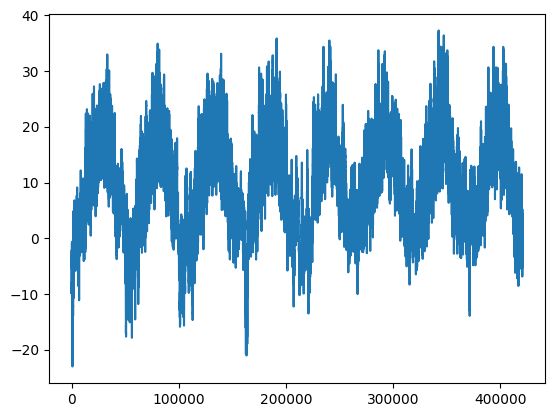

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**Plotting the first 10 days of the temperature timeseries**

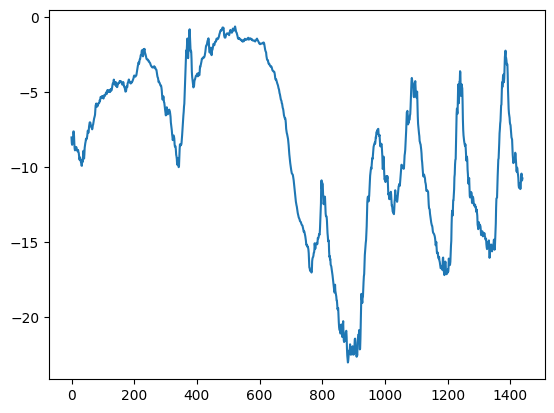

In [8]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**Computing the number of samples we'll use for each data split**

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [12]:
for inputs, targets in dummy_dataset:
  print(inputs.shape)
  print(targets.shape)
  break

(2, 3)
(2,)


**Instantiating datasets for training, validation, and testing**

In [13]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [14]:
raw_data.shape

(420451, 14)

**Inspecting the output of one of our datasets**

In [15]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [17]:
raw_data.shape[-1]

14

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 42s 50ms/step - loss: 12.5160 - mae: 2.7342 - val_loss: 14.0647 - val_mae: 2.9984
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 49s 60ms/step - loss: 9.0402 - mae: 2.3671 - val_loss: 10.9258 - val_mae: 2.6201
Epoch 3/10
819/819 [==============================] - 51s 62ms/step - loss: 8.3658 - mae: 2.2761 - val_loss: 10.5327 - val_mae: 2.5691
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 7.9546 - mae: 2.2191 - val_loss: 14.0149 - val_mae: 2.9841
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 7.6402 - mae: 2.1722 - val_loss: 10.2022 - val_mae: 2.5371
Epoch 6/10
819/819 [==============================] - 49s 60ms/step - loss: 7.3926 - mae: 2.1365 - val_loss: 11.9493 - val_mae: 2.7614
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 7.1772 - mae: 2.1053 - val_loss: 10.9113 - val_mae: 2.6285
Epoch 8/10
819/819 [==============================] - 41s 49ms/step - loss: 7.0070 - mae: 2.0785 - val_loss: 10.7287 - val_mae: 2.6038
Epoch 9/10
819/819 [==============================] - 41s 50ms/ste

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 1680)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                26896     
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26913 (105.13 KB)
Trainable params: 26913 (105.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
120*14

1680

**Plotting results**

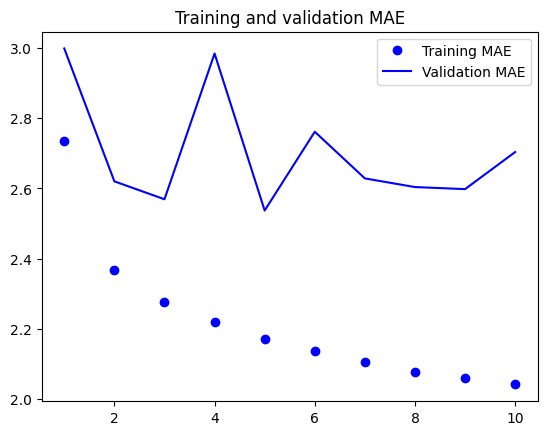

In [22]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 51ms/step - loss: 22.8135 - mae: 3.7304 - val_loss: 18.3457 - val_mae: 3.3977
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 15.2685 - mae: 3.0912 - val_loss: 17.4991 - val_mae: 3.3373
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 13.9872 - mae: 2.9541 - val_loss: 14.8392 - val_mae: 3.0276
Epoch 4/10
819/819 [==============================] - 50s 60ms/step - loss: 13.1900 - mae: 2.8682 - val_loss: 16.2631 - val_mae: 3.2161
Epoch 5/10
819/819 [==============================] - 50s 61ms/step - loss: 12.5574 - mae: 2.7990 - val_loss: 18.1082 - val_mae: 3.3413
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 12.0749 - mae: 2.7416 - val_loss: 16.2828 - val_mae: 3.1580
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 11.6654 - mae: 2.6948 - val_loss: 15.3043 - val_mae: 3.0898
Epoch 8/10
819/819 [============================

In [24]:
24*14*8+8

2696

In [25]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

### A first recurrent baseline

**A simple LSTM-based model**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 53ms/step - loss: 37.4977 - mae: 4.4260 - val_loss: 11.8025 - val_mae: 2.6215
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 10.6263 - mae: 2.5375 - val_loss: 9.9109 - val_mae: 2.4424
Epoch 3/10
819/819 [==============================] - 45s 54ms/step - loss: 9.6649 - mae: 2.4275 - val_loss: 9.6774 - val_mae: 2.4132
Epoch 4/10
819/819 [==============================] - 43s 53ms/step - loss: 9.2429 - mae: 2.3722 - val_loss: 9.4126 - val_mae: 2.3880
Epoch 5/10
819/819 [==============================] - 51s 62ms/step - loss: 8.9963 - mae: 2.3384 - val_loss: 9.4651 - val_mae: 2.3915
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 8.7828 - mae: 2.3095 - val_loss: 9.4646 - val_mae: 2.3883
Epoch 7/10
819/819 [==============================] - 51s 63ms/step - loss: 8.6042 - mae: 2.2849 - val_loss: 9.3505 - val_mae: 2.3808
Epoch 8/10
819/819 [==============================] - 43s 5

In [27]:
4*((14*16) + (16*16) + 16 )

1984

In [28]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 416s 501ms/step - loss: 26.2327 - mae: 3.7874 - val_loss: 9.6291 - val_mae: 2.3996
Epoch 2/10
819/819 [==============================] - 408s 498ms/step - loss: 14.6312 - mae: 2.9672 - val_loss: 9.2577 - val_mae: 2.3673
Epoch 3/10
819/819 [==============================] - 396s 483ms/step - loss: 13.7299 - mae: 2.8747 - val_loss: 9.5376 - val_mae: 2.4012
Epoch 4/10
819/819 [==============================] - 406s 495ms/step - loss: 13.1177 - mae: 2.8066 - val_loss: 9.2882 - val_mae: 2.3752
Epoch 5/10
819/819 [==============================] - 408s 498ms/step - loss: 12.6862 - mae: 2.7596 - val_loss: 9.4040 - val_mae: 2.3877
Epoch 6/10
819/819 [==============================] - 405s 494ms/step - loss: 12.2939 - mae: 2.7159 - val_loss: 9.9920 - val_mae: 2.4592
Epoch 7/10
819/819 [==============================] - 403s 492ms/step - loss: 11.9427 - mae: 2.6768 - val_loss: 9.5726 - val_mae: 2.4044
Epoch 8/10
819/819 [=====================

In [30]:
model = keras.models.load_model("jena_lstm_dropout.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 29s 69ms/step - loss: 10.6825 - mae: 2.5724
Test MAE: 2.57


### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 726s 881ms/step - loss: 24.2111 - mae: 3.6392 - val_loss: 9.2475 - val_mae: 2.3494
Epoch 2/10
819/819 [==============================] - 723s 883ms/step - loss: 14.1088 - mae: 2.9088 - val_loss: 8.9192 - val_mae: 2.3119
Epoch 3/10
819/819 [==============================] - 727s 887ms/step - loss: 13.2992 - mae: 2.8284 - val_loss: 9.2815 - val_mae: 2.3797
Epoch 4/10
819/819 [==============================] - 732s 894ms/step - loss: 12.6733 - mae: 2.7619 - val_loss: 8.7308 - val_mae: 2.2827
Epoch 5/10
819/819 [==============================] - 719s 878ms/step - loss: 12.1907 - mae: 2.7104 - val_loss: 8.7456 - val_mae: 2.2917
Epoch 6/10
819/819 [==============================] - 724s 884ms/step - loss: 11.7253 - mae: 2.6605 - val_loss: 8.7813 - val_mae: 2.3031
Epoch 7/10
819/819 [==============================] - 726s 887ms/step - loss: 11.4515 - mae: 2.6286 - val_loss: 9.4854 - val_mae: 2.3967
Epoch 8/10
819/819 [=====================

405/405 [==============================] - 39s 95ms/step - loss: 9.6435 - mae: 2.4268
Test MAE: 2.43


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 50s 55ms/step - loss: 27.4111 - mae: 3.7603 - val_loss: 10.8478 - val_mae: 2.5506
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 9.7100 - mae: 2.4301 - val_loss: 9.8419 - val_mae: 2.4286
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 8.7976 - mae: 2.3125 - val_loss: 9.9379 - val_mae: 2.4400
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 8.3658 - mae: 2.2526 - val_loss: 10.3095 - val_mae: 2.4851
Epoch 5/10
819/819 [==============================] - 46s 55ms/step - loss: 7.9743 - mae: 2.1976 - val_loss: 10.5461 - val_mae: 2.5059
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 7.5357 - mae: 2.1393 - val_loss: 10.3521 - val_mae: 2.4856
Epoch 7/10
819/819 [==============================] - 44s 54ms/step - loss: 7.1976 - mae: 2.0919 - val_loss: 10.8630 - val_mae: 2.5259
Epoch 8/10
819/819 [==============================] - 45

In [33]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 14s 34ms/step - loss: 11.4110 - mae: 2.6516
Test MAE: 2.65


Done!